In [1]:
import numpy as np
import pylab as plt
import seaborn as sns
from scipy import optimize
import matplotlib
import pickle
from numerics import find_coefficients_Huber, find_coefficients_L2
import time
from sklearn.linear_model import HuberRegressor

In [2]:
%%time

import glmnet_python    
from cvglmnet import cvglmnet
from cvglmnetPlot import cvglmnetPlot

glob_max_iter = 1000

X = np.loadtxt('./data/livertoxicity-gene.txt')
Y = np.loadtxt('./data/livertoxicity-clinic.txt')
print('X shape:', X.shape)
print('Y shape:', Y.shape)

np.random.seed(42)
X = X[:, np.random.permutation(X.shape[1])]
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
Y = Y - np.mean(Y, axis=0)
Y = Y / np.std(Y, axis=0)

# comment this if one doesn't want to use the intercept
X = np.hstack((np.ones(X.shape[0])[:,None], X))

X shape: (64, 3116)
Y shape: (64, 10)
CPU times: user 112 ms, sys: 15.5 ms, total: 127 ms
Wall time: 157 ms


In [3]:
def huber_leave_one_out_cv_sklearn(X, y, reg_param, alpha, a, max_iter=10000):
    means = np.empty(X.shape[0])
    for idx in range(X.shape[0]):
        n_data_train = X.shape[0] - 1
        n_features = int(np.around(n_data_train / alpha))
        train_X = np.delete(X, idx, axis=0)[:,:n_features]
        train_y = np.delete(y, idx, axis=0)

        test_X = X[idx,:n_features].reshape(1,-1)
        test_y = y[idx]

        huber = HuberRegressor(epsilon=a, alpha=reg_param, max_iter=max_iter, warm_start=True).fit(train_X, train_y)
        means[idx] = np.mean((huber.predict(test_X) - test_y)**2)
    return np.mean(means)

In [4]:
def L2_leave_one_out_cv(X, y, reg_param, alpha):
    means = np.empty(X.shape[0])
    n_data_train = X.shape[0] - 1
    n_features = int(np.around(n_data_train / alpha))
    for idx in range(X.shape[0]):
        train_X = np.delete(X, idx, axis=0)[:,:n_features]
        train_y = np.delete(y, idx, axis=0)

        test_X = X[idx,:n_features].reshape(1,-1)
        test_y = y[idx]

        # huber = HuberRegressor(alpha=reg_param, max_iter=max_iter, warm_start=True).fit(train_X, train_y)
        # w_0 = inital_conditions[idx,:]
        w_hat = find_coefficients_L2(train_y, train_X, reg_param)
        means[idx] = np.mean((test_X @ w_hat - test_y)**2)
        # inital_conditions[idx,:] = w_hat
    return np.mean(means)

In [4]:
def huber_leave_one_out_cv(X, y, reg_param, alpha, a, inital_conditions=None, max_iter=10000):
    means = np.empty(X.shape[0])
    n_data_train = X.shape[0] - 1
    n_features = int(np.around(n_data_train / alpha))
    for idx in range(X.shape[0]):
        train_X = np.delete(X, idx, axis=0)[:,:n_features]
        train_y = np.delete(y, idx, axis=0)

        test_X = X[idx,:n_features].reshape(1,-1)
        test_y = y[idx]

        # huber = HuberRegressor(alpha=reg_param, max_iter=max_iter, warm_start=True).fit(train_X, train_y)
        w_0 = inital_conditions[idx,:]
        w_hat = find_coefficients_Huber(train_y, train_X, reg_param, a, inital_guess=w_0, max_iter=max_iter)
        means[idx] = np.mean((test_X @ w_hat - test_y)**2)
        inital_conditions[idx,:] = w_hat
    return np.mean(means)

n_features  210
0 1 2 3 4 5 6 7 8 9 
. . . . . . . . . . 


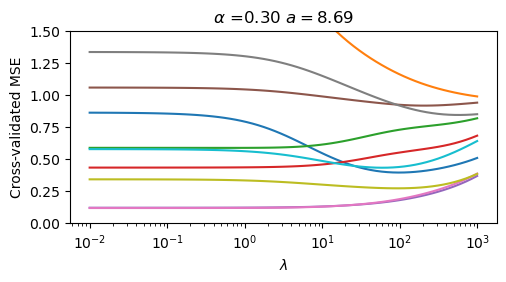

In [25]:
# lambda sweep for Huber
p = 50
# alpha = 1.25
alpha = 0.3
# alpha = 32.0
alpha = max(63/3116, alpha)

plt.figure(figsize=(5.5,2.5))

a_huber = 10000.0
a_huber = 8.68511373751352
N = 70
reg_params = np.logspace(-2, 3, N)
cv_MSE_full = np.empty((N, Y.shape[1]))

print("n_features ", int(np.around((X.shape[0]-1) / alpha)))

# for subplotnum, p in enumerate(ps):
for i in range(Y.shape[1]):
    print('{:d} '.format(i),end='')
print("")

for i in range(Y.shape[1]):
    print('. ', end='')
    y = Y[:,i]

    n_features = int(np.around((X.shape[0]-1) / alpha))
    init_cond = np.random.random((X.shape[0], n_features))

    # start = time.time()
    # create a list of train_X, train_y, test_X, test_y that will be used by the function huber_leave_one_out_cv
    list_train_X = [np.delete(X, idx, axis=0)[:,:n_features] for idx in range(X.shape[0])]
    list_train_y = [np.delete(y, idx, axis=0) for idx in range(X.shape[0])]
    list_test_X = [X[idx,:n_features].reshape(1,-1) for idx in range(X.shape[0])]
    list_test_y = [y[idx] for idx in range(X.shape[0])]
    end = time.time()
    # print("{:.3f}".format(end - start))

    cv_MSE = np.empty_like(reg_params)

    for idx, rp in enumerate(reg_params[::-1]):
        start = time.time()
        # cv_MSE[N - 1 - idx] = L2_leave_one_out_cv(X, y, rp, alpha)
        cv_MSE[N - 1 - idx] = huber_leave_one_out_cv(X, y.copy(), rp, alpha, a_huber, inital_conditions=init_cond)
        # cv_MSE[N - 1 - idx] = huber_leave_one_out_cv_sklearn(X, y.copy(), rp, alpha, a_huber)
        cv_MSE_full[N - 1 - idx, i] = cv_MSE[N - 1 - idx]
        end = time.time()
        # print("{:d} time {:.3f}".format(idx, end - start))
        # print('{:d} {:.3f}'.format(idx, rp))

    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(reg_params, cv_MSE, '-', color=color)

    # plt.plot(fit['lambda_min'], np.min(fit['cvm']), 'o', color=color, clip_on=False)
print('')

plt.title(r"$\alpha $ =" + "{:.2f}".format(alpha) + r" $a = $" + "{:.2f}".format(a_huber))
plt.xlabel(r'$\lambda$')
plt.ylabel('Cross-validated MSE')
# plt.title('liver.toxicity data set. $n=64$, $p=' + str(p) + '$')
plt.xscale('log')
plt.ylim([0, 1.5])
plt.show()


In [10]:
# np.savetxt(
#     "cv_MSE_full_alpha_{:.2f}_a_{:.2f}.csv".format(alpha, a_huber),
#     np.hstack((reg_params[:,None], cv_MSE_full)),
#     delimiter=",",
#     header="reg_param,components"
# )

-----------------------------

In [30]:
# a sweep for Huber
p = 50
alpha = 0.3
alpha = max(63/3116, alpha)

plt.figure(figsize=(7,2.5))

rp = 1e3
N = 20

print("n_features ", int(np.around((X.shape[0]-1) / alpha)))

cv_MSE_full = np.empty((N, Y.shape[1]))
# big lambda 
a_hubers = np.logspace(3, 1, N)
# smalle lambda
# a_hubers = np.logspace(-5, 1, N)

# for subplotnum, p in enumerate(ps):
for i in range(Y.shape[1]):
    print('{:d} '.format(i),end='')
print("")

for i in range(Y.shape[1]):
    print('. ', end='')
    y = Y[:,i]

    n_features = int(np.around((X.shape[0]-1) / alpha))
    init_cond = np.random.random((X.shape[0], n_features))

    # start = time.time()
    # create a list of train_X, train_y, test_X, test_y that will be used by the function huber_leave_one_out_cv
    list_train_X = [np.delete(X, idx, axis=0)[:,:n_features] for idx in range(X.shape[0])]
    list_train_y = [np.delete(y, idx, axis=0) for idx in range(X.shape[0])]
    list_test_X = [X[idx,:n_features].reshape(1,-1) for idx in range(X.shape[0])]
    list_test_y = [y[idx] for idx in range(X.shape[0])]
    end = time.time()
    # print("{:.3f}".format(end - start))

    cv_MSE = np.empty_like(a_hubers)

    for idx, a_huber in enumerate(a_hubers[::-1]):
        print("a_value: ", a_huber)
        start = time.time()
        cv_MSE[N - 1 - idx] = huber_leave_one_out_cv(X, y.copy(), rp, alpha, a_huber, inital_conditions=init_cond)
        # cv_MSE[N - 1 - idx] = huber_leave_one_out_cv_sklearn(X, y.copy(), rp, alpha, a_huber)
        cv_MSE_full[N - 1 - idx, i] = cv_MSE[N - 1 - idx]
        end = time.time()
        # print("{:d} time {:.3f}".format(idx, end - start))
        # print('{:d} {:.3f}'.format(idx, rp))

    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(a_hubers, cv_MSE, '-', color=color)

    # plt.plot(fit['lambda_min'], np.min(fit['cvm']), 'o', color=color, clip_on=False)
print('')

plt.title(r"$\alpha $ =" + "{:.2f}".format(alpha) + r" $\lambda = $" + "{:.2f}".format(rp))
plt.xlabel(r'$a$')
plt.ylabel('Cross-validated MSE')
# plt.title('liver.toxicity data set. $n=64$, $p=' + str(p) + '$')
plt.xscale('log')
plt.ylim([0, 1.2])
# plt.xlim([10**-5,10**10])
# sns.despine()
plt.show()

n_features  210
0 1 2 3 4 5 6 7 8 9 
. a_value:  10.0
a_value:  12.742749857031342
a_value:  16.237767391887225
a_value:  20.6913808111479
a_value:  26.366508987303583
a_value:  33.59818286283783
a_value:  42.81332398719396
a_value:  54.5559478116852
a_value:  69.51927961775606
a_value:  88.58667904100828
a_value:  112.88378916846895
a_value:  143.8449888287663
a_value:  183.29807108324357
a_value:  233.57214690901213
a_value:  297.63514416313194


ValueError: HuberRegressor convergence failed: l-BFGS-b solver terminated with ABNORMAL_TERMINATION_IN_LNSRCH

<Figure size 700x250 with 0 Axes>

In [8]:
np.savetxt(
    'cv_MSE_full_lambda_{:.3f}_alpha_{:.2f}.csv'.format(rp, alpha), 
    np.hstack((a_hubers[:,None], cv_MSE_full)), 
    header="a,outputs",
    delimiter=','
)

In [103]:
def huber_leave_one_out_cv_optimized_a(X, y, reg_param, alpha, a0 = 0.5, inital_conditions=None, max_iter=10000):
    # as_huber = np.logspace(0, 1, 10)
    # cv_MSE = np.empty_like(as_huber)
    
    # for idx, a in enumerate(as_huber):
    #     cv_MSE[idx] = huber_leave_one_out_cv(X, y, reg_param, alpha, a, inital_conditions=inital_conditions, max_iter=max_iter)
    
    # a_opt = as_huber[np.argmin(cv_MSE)]
    # fun_min_val = np.min(cv_MSE)
    # return fun_min_val, a_opt
    
    def huber_leave_one_out_cv_a_optim(a):
        return huber_leave_one_out_cv(X, y, reg_param, alpha, a, inital_conditions=inital_conditions, max_iter=max_iter)
    
    # obj = optimize.minimize(
    #     huber_leave_one_out_cv_a_optim,
    #     x0=a0,
    #     method='Nelder-Mead',
    #     tol=1e-3,
    #     bounds=[(1e-7, 1e4)]
    #     # options={'maxiter': 200, "disp":True},
    # )
    
    obj = optimize.minimize_scalar(
        huber_leave_one_out_cv_a_optim,
        # x0=a0,
        method='bounded',
        # tol=1e-4,
        bounds=(1e-6, 100),
        options={'xatol' : 1e-4},
    )

    if obj.success:
        fun_min_val = obj.fun
        a_opt = obj.x

        return fun_min_val, a_opt
    else:
        raise RuntimeError('Optimization failed')


n_features  2100
. 0 reg_p 316.228 time 14.566 0.6586220395513819 38.196601743044496
1 reg_p 254.564 time 12.977 0.6464206622427833 99.99994784878287
2 reg_p 204.925 time 11.671 0.6340566817321176 66.20585390743341
3 reg_p 164.965 time 13.716 0.6216630597298896 99.99994784878287
4 reg_p 132.797 time 13.388 0.6093645712618736 57.620059002869546
5 reg_p 106.902 time 13.810 0.5973002349852543 99.99994784878287
6 reg_p 86.056 time 11.231 0.5855965539254808 37.4701638906922
7 reg_p 69.276 time 13.823 0.5743994032875878 1.7361396898455579
8 reg_p 55.767 time 13.454 0.563854136255719 66.3502800745179
9 reg_p 44.893 time 14.897 0.5540592512964625 66.24339146701273
10 reg_p 36.139 time 10.733 0.5451060912036613 69.44618689969136
11 reg_p 29.092 time 13.442 0.5370637918377347 78.80323170442036
12 reg_p 23.419 time 13.486 0.5299287189631545 87.1827048393284
13 reg_p 18.852 time 15.267 0.5236844222870262 55.0427945318507
14 reg_p 15.176 time 11.594 0.5183011832139507 53.49449973734599
15 reg_p 12.

KeyboardInterrupt: 

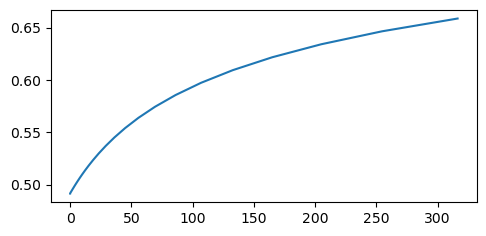

In [105]:
# ps = [50, X.shape[1]]
p = 50
alpha = 0.03
alpha = max(63/3116, alpha)

n_features = int(np.around((X.shape[0]-1) / alpha))
init_cond = np.random.random((X.shape[0], n_features))

N = 70
reg_params = np.logspace(-4, 2.5, N)
cv_MSE = np.empty_like(reg_params)
cv_MSE_full = np.empty((N, Y.shape[1]))
a_opt = np.empty_like(reg_params)
a_opt_full = np.empty((N, Y.shape[1]))

print("n_features ", n_features)

plt.figure(figsize=(5.5,2.5))

# for subplotnum, p in enumerate(ps):
# for i in range(Y.shape[1]-5):
#     print('{:d} '.format(i),end='')
# print("")

for i in range(0, Y.shape[1]): # Y.shape[1]-5
    # i = 9
    print('. ', end='')
    y = Y[:,i]


    # start = time.time()
    # create a list of train_X, train_y, test_X, test_y that will be used by the function huber_leave_one_out_cv
    list_train_X = [np.delete(X, idx, axis=0)[:,:n_features] for idx in range(X.shape[0])]
    list_train_y = [np.delete(y, idx, axis=0) for idx in range(X.shape[0])]
    list_test_X = [X[idx,:n_features].reshape(1,-1) for idx in range(X.shape[0])]
    list_test_y = [y[idx] for idx in range(X.shape[0])]
    end = time.time()
    # print("{:.3f}".format(end - start))

    old_a = 0.5
    for idx, rp in enumerate(reg_params[::-1]):
        start = time.time()
        cv_MSE[N - 1 - idx], a_opt[N - 1 - idx] = huber_leave_one_out_cv_optimized_a(X, y.copy(), rp, alpha, a0 = old_a, inital_conditions=init_cond)
        cv_MSE_full[N - 1 - idx, i] = cv_MSE[N - 1 - idx]
        a_opt_full[N - 1 - idx, i] = a_opt[N - 1 - idx]
        old_a = a_opt[N - 1 - idx]
        end = time.time()
        print("{:d} reg_p {:.3f} time {:.3f}".format(idx, rp, end - start), cv_MSE[N - 1 - idx], a_opt[N - 1 - idx])
        # print("{:d} time {:.3f}".format(idx, end - start))
        # print('{:d} {:.3f}'.format(idx, rp))

    np.savetxt(
        'full_comp_{}_cv_MSE_lambda_sweep_a_opt_alpha_{:.2f}.csv'.format(i, alpha),
        np.hstack((reg_params[:,None], cv_MSE[:,None], a_opt[:,None])),
        header="lambda,outputs,a_opt",
        delimiter=','
    )
    # old_a = 0.5
    # for idx, rp in enumerate(reg_params):
    #     start = time.time()
    #     cv_MSE[  idx], a_opt[  idx] = huber_leave_one_out_cv_optimized_a(X, y.copy(), rp, alpha, a0 = old_a, inital_conditions=init_cond)
    #     cv_MSE_full[ idx, i] = cv_MSE[ idx]
    #     a_opt_full[ idx, i] = a_opt[ idx]
    #     old_a = a_opt[ idx]
    #     end = time.time()
    #     print("{:d} reg_p {:.3f} time {:.3f}".format(idx, rp, end - start), cv_MSE[ idx], a_opt[ idx])
    #     # print("{:d} time {:.3f}".format(idx, end - start))

    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(reg_params, cv_MSE, '-', color=color)

    # plt.plot(fit['lambda_min'], np.min(fit['cvm']), 'o', color=color, clip_on=False)
print('')

plt.xlabel(r'$\lambda$')
plt.ylabel('Cross-validated MSE')
# plt.title('liver.toxicity data set. $n=64$, $p=' + str(p) + '$')
plt.xscale('log')
plt.ylim([0, 2])
# plt.xlim([10**-5,10**10])
# sns.despine()
plt.show()


In [ ]:
# np.savetxt(
#     'comp_{}_cv_MSE_lambda_sweep_a_opt_alpha_{:.2f}.csv'.format(i, alpha),
#     np.hstack((reg_params[:,None], cv_MSE_full[:,i][:,None], a_opt_full[:,i][:,None])),
#     header="lambda,outputs,a_opt",
#     delimiter=','
# )